In [2]:
import os
import librosa
import librosa.effects
import numpy as np
import soundfile as sf
from moviepy import VideoClip
from tqdm import tqdm
from tensorflow.keras.models import load_model
from collections import defaultdict
import matplotlib.pyplot as plt

In [6]:
TARGET_SR = 16000
TARGET_DURATION = 1
TARGET_LEN = int(TARGET_SR * TARGET_DURATION)
CHUNK_SOURCE_DURATION = 12
CHUNK_SOURCE_LEN = int(CHUNK_SOURCE_DURATION * TARGET_SR)

CLASS_LABELS = ['ambient', 'conversation', 'scream']

In [7]:
def convert_mp4_to_wav(mp4_path, wav_path):
    audio_clip = mp.AudioFileClip(mp4_path)
    audio_clip.write_audiofile(wav_path)
    audio_clip.close()


In [8]:
# Containers for stats
# category_stats['conversation']['durations'] = [ ... ]
category_stats = defaultdict(lambda: defaultdict(list))
overall_durations = []
overall_srs = []

In [9]:
def print_stats_summary(cat_stats, all_srs, all_durs):
    def stats(arr):
        a = np.array(arr)
        return a.mean(), a.min(), a.max()

    print("\n=== OVERALL STATS ===")
    mean_sr, min_sr, max_sr = stats(all_srs)
    mean_dur, min_dur, max_dur = stats(all_durs)
    print(f"Sample Rate — avg: {mean_sr:.0f}, min: {min_sr}, max: {max_sr}")
    print(f"Duration    — avg: {mean_dur:.2f}s, min: {min_dur:.2f}s, max: {max_dur:.2f}s")

    for cat, stats_dict in cat_stats.items():
        print(f"\n--- {cat.upper()} ---")
        msr, nsr, xsr = stats(stats_dict['orig_srs'])
        mdur, ndur, xdur = stats(stats_dict['orig_durations'])
        print(f"Original SR — avg: {msr:.0f}, min: {nsr}, max: {xsr}")
        print(f"Orig Duration — avg: {mdur:.2f}s, min: {ndur:.2f}s, max: {xdur:.2f}s")
        # You could also stats on proc_durations if you like:
        # ps = stats(stats_dict['proc_durations'])
        # …


In [10]:
def clean_and_process_audio(file_path, output_folder):
    try:
        # Convert MP4 to WAV if needed
        if file_path.lower().endswith('.mp4'):
            file_path = convert_mp4_to_wav(file_path)

        # Load as mono, resampled
        y, _ = librosa.load(file_path, sr=TARGET_SR, mono=True)
        y, _ = librosa.effects.trim(y, top_db=10)
        n = len(y)

        def stretch_to_one_sec(segment):
            rate = len(segment) / TARGET_LEN
            return librosa.effects.time_stretch(y=segment, rate=rate)

        # If the audio is longer than our source‑chunk length, break it into 6 s chunks...
        if n > CHUNK_SOURCE_LEN:
            hop = CHUNK_SOURCE_LEN
            base = os.path.splitext(os.path.basename(file_path))[0]
            for idx, start in enumerate(range(0, n, hop)):
                seg = y[start:start + hop]
                out = stretch_to_one_sec(seg)
                fname = f"{base}_chunk{idx}.wav"
                sf.write(os.path.join(output_folder, fname), out, TARGET_SR)

        # …otherwise, stretch the entire file to exactly 1 sec
        else:
            out = stretch_to_one_sec(y)
            fname = os.path.basename(file_path)
            sf.write(os.path.join(output_folder, fname), out, TARGET_SR)

        # Return original sample‐rate and durations
        info = sf.info(file_path)
        orig_sr = info.samplerate
        orig_dur = info.frames / orig_sr
        return orig_sr, orig_dur, TARGET_DURATION

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None, None


In [11]:
def process_dataset(raw_base, processed_base):
    for category in CLASS_LABELS:
        input_folder = os.path.join(raw_base, category)
        output_folder = os.path.join(processed_base, category)
        os.makedirs(output_folder, exist_ok=True)

        print(f"Processing {category}…")
        for fname in tqdm(os.listdir(input_folder)):
            if fname.lower().endswith(('.wav', '.mp4')):
                file_path = os.path.join(input_folder, fname)
                orig_sr, orig_dur, proc_dur = clean_and_process_audio(
                    file_path, output_folder
                )
                if orig_sr is not None:
                    # add to per‐category lists
                    category_stats[category]['orig_srs'].append(orig_sr)
                    category_stats[category]['orig_durations'].append(orig_dur)
                    category_stats[category]['proc_durations'].append(proc_dur)

                    # add to overall lists
                    overall_srs.append(orig_sr)
                    overall_durations.append(orig_dur)

    # After all categories are done, print summary
    print_stats_summary(category_stats, overall_srs, overall_durations)

In [13]:
raw_base = 'data'
processed_base = 'data/processed_data'

# Start processing
process_dataset(raw_base, processed_base)

Processing ambient…


 20%|█▉        | 393/2000 [00:07<00:48, 32.85it/s]c:\Users\Yashraj\Desktop\AUDIO CLASSIFIER\audio\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1536
  warnings.warn(
100%|██████████| 2000/2000 [01:00<00:00, 33.04it/s]


Processing conversation…


100%|██████████| 128/128 [01:08<00:00,  1.86it/s]


Processing scream…


100%|██████████| 1583/1583 [00:41<00:00, 38.16it/s]


=== OVERALL STATS ===
Sample Rate — avg: 33151, min: 16000, max: 44100
Duration    — avg: 11.09s, min: 0.41s, max: 552.40s

--- AMBIENT ---
Original SR — avg: 44100, min: 44100, max: 44100
Orig Duration — avg: 5.00s, min: 5.00s, max: 5.00s

--- CONVERSATION ---
Original SR — avg: 41513, min: 20000, max: 44100
Orig Duration — avg: 225.07s, min: 112.18s, max: 552.40s

--- SCREAM ---
Original SR — avg: 16000, min: 16000, max: 16000
Orig Duration — avg: 2.96s, min: 0.41s, max: 11.83s


In [14]:
def extract_mel_spectrogram(file_path, sr=16000, n_mels=128, n_fft=400, hop_length=160):
    y, _ = librosa.load(file_path, sr=sr)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, power=2.0)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

In [15]:
def process_all_audio_to_melspec(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for category in CLASS_LABELS:
        category_path = os.path.join(input_dir, category)
        output_category_path = os.path.join(output_dir, category)
        os.makedirs(output_category_path, exist_ok=True)

        print(f"Processing category: {category}")
        for fname in tqdm(os.listdir(category_path)):
            if fname.endswith('.wav'):
                file_path = os.path.join(category_path, fname)
                mel_spec = extract_mel_spectrogram(file_path)
                output_path = os.path.join(output_category_path, fname.replace('.wav', '.npy'))
                np.save(output_path, mel_spec)

In [16]:
input_dir = "data/processed_data"
output_dir = "data/processed_melspec"

process_all_audio_to_melspec(input_dir, output_dir)

Processing category: ambient


100%|██████████| 2000/2000 [00:29<00:00, 66.87it/s]


Processing category: conversation


100%|██████████| 2254/2254 [00:32<00:00, 68.90it/s]


Processing category: scream


100%|██████████| 1583/1583 [00:23<00:00, 68.45it/s]


In [17]:
def load_data(melspec_dir):
    # Define the LABEL_MAP within the function
    LABEL_MAP = {label: i for i, label in enumerate(CLASS_LABELS)}

    X = []
    y = []
    for category in CLASS_LABELS:
        folder = os.path.join(melspec_dir, category)
        for fname in os.listdir(folder):
            if fname.endswith('.npy'):
                filepath = os.path.join(folder, fname)
                mel = np.load(filepath)
                X.append(mel)
                y.append(LABEL_MAP[category])

    X = np.array(X)
    y = np.array(y)
    X = (X - X.min()) / (X.max() - X.min())  # Normalize
    X = X[..., np.newaxis]  # Add channel dim

    # Import train_test_split here if not already imported globally
    from sklearn.model_selection import train_test_split
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

def build_model(input_shape):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2,2)), Dropout(0.2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)), Dropout(0.3),
        Flatten(),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dense(len(CLASS_LABELS), activation='softmax') # Assuming CLASS_LABELS is defined somewhere
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [19]:
X_train, X_val, y_train, y_val = load_data("data/processed_melspec")


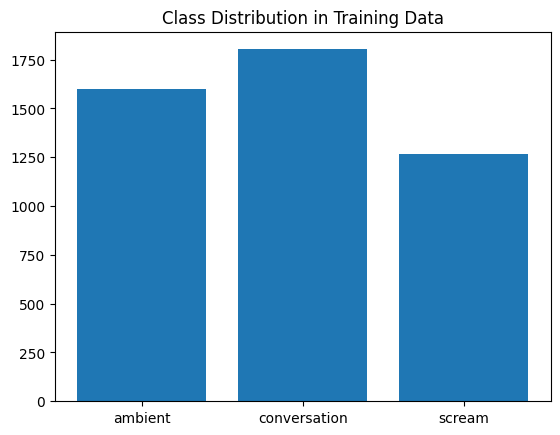

In [20]:
import matplotlib.pyplot as plt

# Count samples per class in training data
class_counts = np.bincount(y_train)
plt.bar(CLASS_LABELS, class_counts)
plt.title('Class Distribution in Training Data')
plt.show()

In [21]:
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train, num_classes=len(CLASS_LABELS))
y_val_cat = to_categorical(y_val, num_classes=len(CLASS_LABELS))

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def train_model(model, X_train, y_train, X_val, y_val):
    # Create callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=0.000005
    )

    # Train with more appropriate parameters for small dataset
    return model.fit(
        X_train, y_train,
        epochs=25,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping]
        # class_weight={
        #     0: .5,
        #     1: 5,
        #     2: 0.5
        # }
    )

model = build_model(X_train.shape[1:])
history = train_model(model, X_train, y_train_cat, X_val, y_val_cat)

c:\Users\Yashraj\Desktop\AUDIO CLASSIFIER\audio\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 28s 179ms/step - accuracy: 0.5119 - loss: 1.1487 - val_accuracy: 0.8236 - val_loss: 0.4707
Epoch 2/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 25s 170ms/step - accuracy: 0.8090 - loss: 0.5011 - val_accuracy: 0.8348 - val_loss: 0.4101
Epoch 3/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 22s 152ms/step - accuracy: 0.8417 - loss: 0.4164 - val_accuracy: 0.8459 - val_loss: 0.3927
Epoch 4/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 24s 165ms/step - accuracy: 0.8483 - loss: 0.3837 - val_accuracy: 0.8510 - val_loss: 0.3427
Epoch 5/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.8759 - loss: 0.3367 - val_accuracy: 0.8793 - val_loss: 0.3151
Epoch 6/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 22s 149ms/step - accuracy: 0.8753 - loss: 0.3166 - val_accuracy: 0.8664 - val_loss: 0.3022
Epoch 7/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 0.8839 - loss: 0.2874 - val_accuracy: 0.8853 - val_loss: 0.2679
Epoch 8/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 22s 154ms/step - accuracy: 0.9067 - loss: 0

In [23]:
import matplotlib.pyplot as plt # Import the pyplot module from matplotlib as plt

def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Val'])
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Val'])
    plt.show()


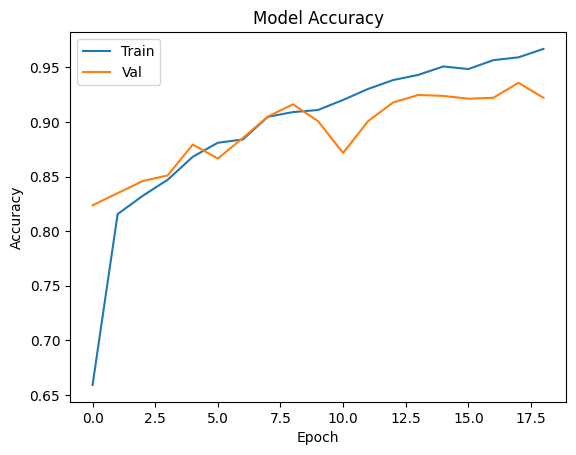

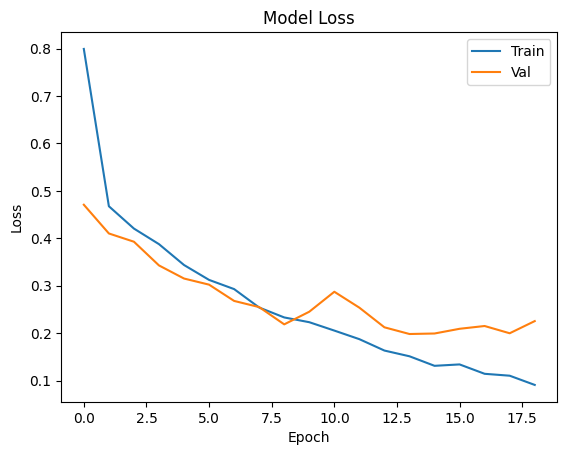

In [24]:
plot_history(history)

In [32]:

def stretch_to_target(y_segment):
    rate = len(y_segment) / TARGET_LEN
    return librosa.effects.time_stretch(y=y_segment, rate=rate)


def predict_audio(file_path, model, CLASS_LABELS):
    if file_path.lower().endswith('.mp4'):
        file_path = convert_mp4_to_wav(file_path)

    y, _ = librosa.load(file_path, sr=TARGET_SR, mono=True)
    y, _ = librosa.effects.trim(y, top_db=10)
    n = len(y)
    segments = []

    if n > CHUNK_SOURCE_LEN:
        for i in range(0, n, CHUNK_SOURCE_LEN):
            seg = y[i:i + CHUNK_SOURCE_LEN]
            segments.append(stretch_to_target(seg))
    else:
        segments.append(stretch_to_target(y))

    print(f"Number of segments: {len(segments)}")

    if not segments:
        print("No valid segments to predict")
        return None

    predictions = []
    for seg in segments:
        mel = librosa.feature.melspectrogram(y=seg, sr=TARGET_SR, n_fft=400, hop_length=160, n_mels=128, power=2.0)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        mel_db = np.expand_dims(mel_db, axis=0)
        mel_db = np.expand_dims(mel_db, axis=-1)
        pred = model.predict(mel_db, verbose=0)
        predictions.append(np.argmax(pred))
    print("Debug: ", predictions)

    final_class = max(set(predictions), key=predictions.count)
    print(f"Predicted: {CLASS_LABELS[final_class]}")
    return final_class

def evaluate_model(model, X_test, y_test, batch_size=32):
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
    # y_test_categorical = to_categorical(y_test, num_classes=len(CLASS_LABELS))
    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return loss, accuracy


In [26]:
from tensorflow.keras.utils import to_categorical

print(f"X_test shape: {X_val.shape}")
print(f"y_test shape: {y_val_cat.shape}")


evaluate_model(model, X_val, y_val_cat)

X_test shape: (1168, 128, 101, 1)
y_test shape: (1168, 3)
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9152 - loss: 0.2158
Test Loss: 0.1981, Test Accuracy: 0.9247


(0.19813945889472961, 0.9246575236320496)

In [37]:
audio = predict_audio("bus-interior-2.wav", model, CLASS_LABELS)


Number of segments: 5
Debug:  [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Predicted: ambient


In [4]:
def visualize_audio(file_path):
    y, sr = librosa.load(file_path, sr=TARGET_SR)
    y, _ = librosa.effects.trim(y, top_db=10)
    y = librosa.effects.time_stretch(y=y, rate=len(y) / int(TARGET_LEN))
    plt.figure(figsize=(10, 4))
    plt.plot(y)
    plt.title('Waveform')
    plt.show()

    mel = librosa.feature.melspectrogram(y=y, sr=TARGET_SR, n_fft=400, hop_length=160, n_mels=128, power=2.0)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.show()


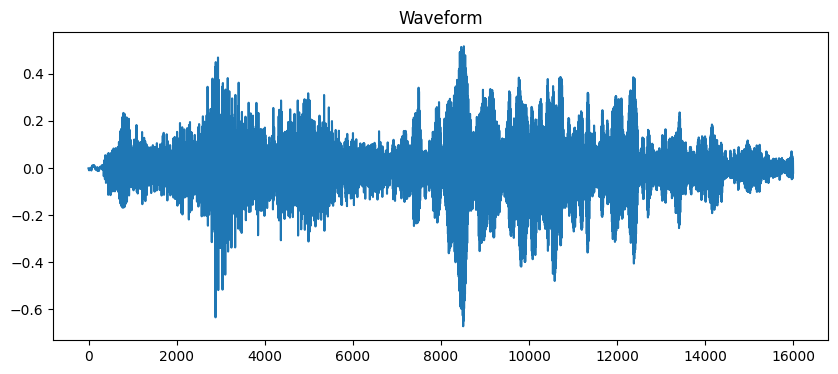

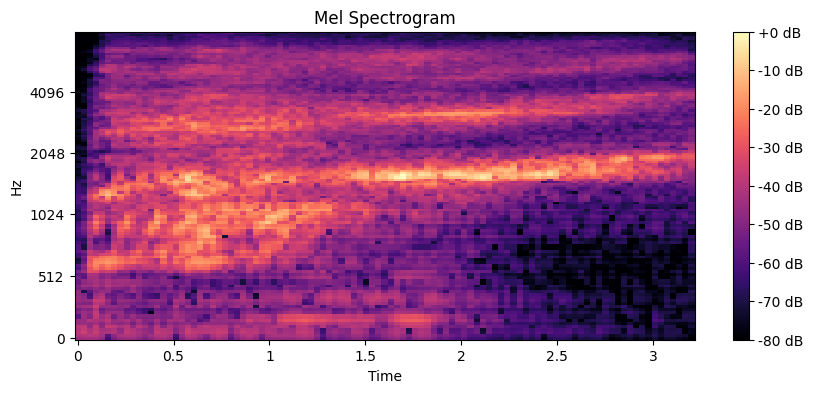

In [42]:
for file in os.listdir("data/scream")[:1]:
    visualize_audio(f"data/scream/{file}")
